In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch 
import torch.nn.functional as F
from torch import nn

from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import adam

from PIL import Image
from torch.utils.data import DataLoader, Dataset

# Data Loading and Pre-processing

In [3]:
#Create a sequence of transformations to be applied on each image
transform = v2.Compose([
    v2.Resize((224,224)),  #Input images are 224 x 224
    v2.PILToTensor(),      #Convert the image to a pytorch tensor
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
class FlickrDataset(Dataset):
    def __init__(self, data_transform):
        self.dataset = pd.read_csv("../Dataset/captions.txt")
        self.transform = data_transform
        self.vocab = {"<START>","<END>", "<PAD>"}
        self.max_line = 0
        self.itos = dict()
        self.stoi = dict()
        self.__load_vocab()

    def __len__(self):
        return len(self.dataset)
    
    def __load_vocab(self):
        for i in range(len(self.dataset)):
            line = self.dataset.iloc[i]['caption']
            self.max_line = max(self.max_line, len(line.split()))
            for word in line.split():
                self.vocab.add(word.lower())
        self.vocab = list(self.vocab)
        self.max_line += 2
        for i in range(len(self.vocab)):
            self.itos[i] = self.vocab[i]
            self.stoi[self.vocab[i]] = i
        
    def __getitem__(self, index):
        img_path = self.dataset.iloc[index]['image']
        img = Image.open('../Dataset/Images/'+img_path)
        img = self.transform(img)
        caption = self.dataset.iloc[index]['caption']
        caption = caption.split()
        caption = [self.vocab.index(word.lower()) for word in caption]
        caption = [self.vocab.index("<START>")] + caption + [self.vocab.index("<END>")]
    
        if (len(caption) < self.max_line):
            caption = caption + [self.vocab.index("<PAD>")] * (self.max_line - len(caption))
        
        caption = torch.tensor(caption)
        return img, caption

In [5]:
dataset = FlickrDataset(transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
def show_image(inp, title=None):
    """Image for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Encoder-Decoder Model

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        
    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim) -> None:
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)

        self.A = nn.Linear(attention_dim,1)

    def forward(self, features, hidden_state):
        u_hs = self.U(features)      #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state)  #(batch_size,attention_dim)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))  #(batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)               #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)           #(batch_size,num_layers)

        alpha = F.softmax(attention_scores, dim=1)               #(batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(2)        #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)

        return alpha, attention_weights

In [9]:
#Attention decoder
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3) -> None:
        super().__init__()
        
        # save the model params
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, decoder_dim)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        #Vectorize the caption
        embeds = self.embedding(captions)

        #Initialise LSTM state
        h, c = self.init_hidden_state(features)
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<START>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha, context = self.attention(features, h)
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<END>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [10]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Model Training

In [11]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [12]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 20
print_every = 100
model.train()
for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(dataloader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(dataloader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps, _ = model.decoder.generate_caption(features,vocab=dataset)
                caption = ' '.join(caps)
                show_image(img[0].cpu(),title=caption)
                
            model.train()

# Save the Model

In [13]:
#Save the model
torch.save(model.state_dict(),"caption_generator.pth")
print("Model saved")

Model saved


Generated Caption: yorkshire teamates waders yorkshire apart daughter emerge sort harness touch waders yorkshire verdant pawing uno uno uno uno pawing uno


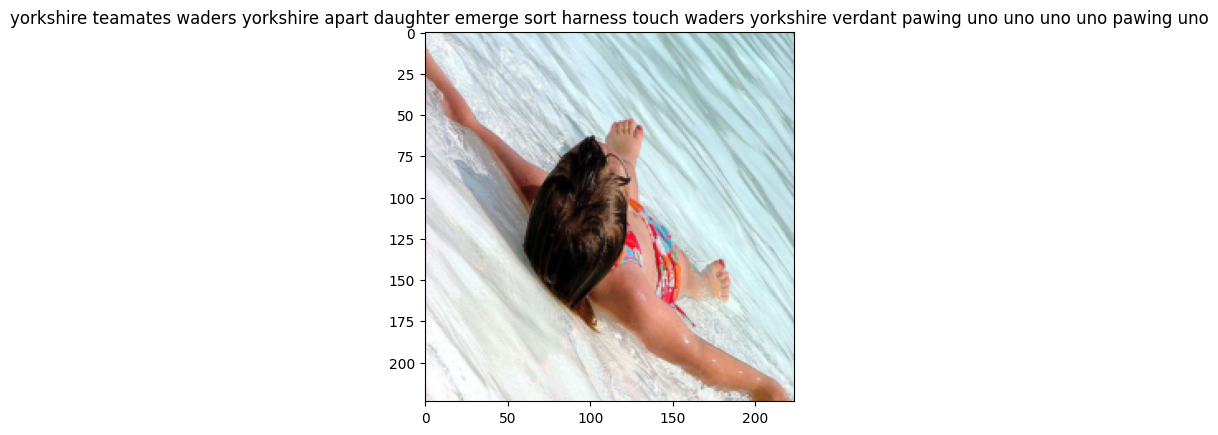

In [16]:
# Load the model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

model.load_state_dict(torch.load("../Models/caption_generator.pth",map_location=torch.device('cpu')))
model.eval()

# Load a sample image
sample_image_path = '../Dataset/Images/667626_18933d713e.jpg'
sample_image = Image.open(sample_image_path)
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Generate caption
with torch.no_grad():
    features = model.encoder(sample_image)
    caption, _ = model.decoder.generate_caption(features, vocab=dataset)

# Print the generated caption
print('Generated Caption:', ' '.join(caption))

# Show the image with the generated caption
show_image(sample_image.cpu().squeeze(), title=' '.join(caption))